In [23]:
import time
import math
import numpy as np
import pylab as py
from matplotlib import pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
from tqdm.auto import tqdm

In [24]:
Me = 6e24  # Mass of Earth in kg
Ms = 2e30  # Mass of Sun in kg
Mj = 1.9e27  # Mass of Jupiter

G = 6.673e-11  # Gravitational Constant

RR = 1.496e11  # Normalizing distance in km (= 1 AU)
MM = 6e24  # Normalizing mass
TT = 365 * 24 * 60 * 60.0  # Normalizing time (1 year)

FF = (G * MM**2) / RR**2  # Unit force
EE = FF * RR  # Unit energy

GG = (MM * G * TT**2) / (RR**3)

Me = Me / MM  # Normalized mass of Earth
Ms = Ms / MM  # Normalized mass of Sun
Mj = 500 * Mj / MM  # Normalized mass of Jupiter/Super Jupiter

In [25]:
def force_es(r):
    F= np.zeros(2)
    Fmag = GG * Me * Ms / (np.linalg.norm(r) + 1e-20) ** 2
    theta = math.atan(np.abs(r[1]) / (np.abs(r[0]) + 1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]

    return F


def force_js(r):
    F = np.zeros(2)
    Fmag = GG * Mj * Ms / (np.linalg.norm(r) + 1e-20) ** 2
    theta = math.atan(np.abs(r[1]) / (np.abs(r[0]) + 1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]

    return F


def force_ej(re, rj):
    r = np.zeros(2)
    F = np.zeros(2)
    r[0] = re[0] - rj[0]
    r[1] = re[1] - rj[1]
    Fmag = GG * Me * Mj / (np.linalg.norm(r) + 1e-20) ** 2
    theta = math.atan(np.abs(r[1]) / (np.abs(r[0]) + 1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]

    return F


def force(r, planet, ro):
    if planet == "earth":
        return force_es(r) + force_ej(r, ro)
    if planet == "jupiter":
        return force_js(r) - force_ej(r, ro)


def dr_dt(t, v, planet, r0):
    return np.array(v)


def dv_dt(t, r, planet, r0):

    F = force(r, planet, r0)
    if planet == "earth":
        y = F / Me
    if planet == "jupiter":
        y = F / Mj
    return y


#################################


def KineticEnergy(v):
    vn = np.linalg.norm(v)
    return 0.5 * Me * vn**2


def PotentialEnergy(r):
    fmag = np.linalg.norm(force_es(r))
    rmag = np.linalg.norm(r)
    return -fmag * rmag


def AngMomentum(r, v):
    rn = np.linalg.norm(r)
    vn = np.linalg.norm(v)
    r = r / rn
    v = v / vn
    rdotv = r[0] * v[0] + r[1] * v[1]
    theta = math.acos(rdotv)
    return Me * rn * vn * np.sin(theta)


def AreaCalc(r1, r2):
    r1n = np.linalg.norm(r1)
    r2n = np.linalg.norm(r2)
    r1 = r1 + 1e-20
    r2 = r2 + 1e-20
    theta1 = math.atan(abs(r1[1] / r1[0]))
    theta2 = math.atan(abs(r2[1] / r2[0]))
    rn = 0.5 * (r1n + r2n)
    del_theta = np.abs(theta1 - theta2)
    return 0.5 * del_theta * rn**2

In [26]:
def rk4_method(t0,v0_earth, v0_jupiter, r0_earth, r0_jupiter, h, n):
    """
    Use the fourth-order Runge-Kutta method (RK4) to solve the numerical solution of ordinary differential equations.

    Parameters:

    dv_dt: Function dv_dt(r, t), representing the differential equation dv/dt = dv_dt(r, t)

    dr_dt: Function dr_dt(v, t), representing the differential equation dr/dt = dr_dt(v, t)

    v0: Initial v value

    r0: Initial r value

    h: Step size

    n: Number of iterations

    Return value: A list containing x and corresponding y values.
    """
    
    t_values = [t0]
    v_values_earth = [v0_earth]
    v_values_jupiter = [v0_jupiter]
    r_values_earth = [r0_earth]
    r_values_jupiter = [r0_jupiter]
    
    for i in tqdm(range(n)):
        # print(i)
        t = t_values[-1]
        
        v_earth = v_values_earth[-1]
        v_jupiter = v_values_jupiter[-1]
        r_earth = r_values_earth[-1]
        r_jupiter = r_values_jupiter[-1]
        
        # Speed    

        l1_earth = h * dv_dt(t, r_earth, 'earth', r_jupiter)
        l2_earth = h * dv_dt(t + h/2, r_earth + h*l1_earth/2, 'earth', r_jupiter)
        l3_earth = h * dv_dt(t + h/2, r_earth + h*l2_earth/2, 'earth', r_jupiter)
        l4_earth = h * dv_dt(t + h, r_earth + h*l3_earth, 'earth', r_jupiter)

        l1_jupiter = h * dv_dt(t, r_jupiter, 'jupiter', r_earth)
        l2_jupiter = h * dv_dt(t + h/2, r_jupiter + h*l1_jupiter/2, 'jupiter', r_earth)
        l3_jupiter = h * dv_dt(t + h/2, r_jupiter + h*l2_jupiter/2, 'jupiter', r_earth)
        l4_jupiter = h * dv_dt(t + h, r_jupiter + h*l3_jupiter, 'jupiter', r_earth)
        
        v_next_earth = v_earth + (l1_earth + 2*l2_earth + 2*l3_earth + l4_earth) / 6
        v_next_jupiter = v_jupiter + (l1_jupiter + 2*l2_jupiter + 2*l3_jupiter + l4_jupiter) / 6

        # Position

        k1_earth = h * dr_dt(t, v_earth, 'earth', r_jupiter)
        k2_earth = h * dr_dt(t + h/2, v_earth + h*k1_earth/2, 'earth', r_jupiter)
        k3_earth = h * dr_dt(t + h/2, v_earth + h*k2_earth/2, 'earth', r_jupiter)
        k4_earth = h * dr_dt(t + h, v_earth + h*k3_earth, 'earth', r_jupiter)

        k1_jupiter = h * dr_dt(t, v_jupiter, 'jupiter', r_jupiter)
        k2_jupiter = h * dr_dt(t + h/2, v_jupiter + h*k1_jupiter/2, 'jupiter', r_jupiter)
        k3_jupiter = h * dr_dt(t + h/2, v_jupiter + h*k2_jupiter/2, 'jupiter', r_jupiter)
        k4_jupiter = h * dr_dt(t + h, v_jupiter + h*k3_jupiter, 'jupiter', r_jupiter)
        
        r_next_earth = r_earth + (k1_earth + 2*k2_earth + 2*k3_earth + k4_earth) / 6
        r_next_jupiter = r_jupiter + (k1_jupiter + 2*k2_jupiter + 2*k3_jupiter + k4_jupiter) / 6

        
        t_next = t + h

        t_values.append(t_next)
        v_values_earth.append(v_next_earth)
        v_values_jupiter.append(v_next_jupiter)
        r_values_earth.append(r_next_earth)
        r_values_jupiter.append(r_next_jupiter)
    
    return np.array(t_values), [np.array(r_values_earth), np.array(r_values_jupiter)], [np.array(v_values_earth), np.array(v_values_jupiter)]

In [27]:
ri = [1496e8 / RR, 0]  # initial position of earth
vv = np.sqrt(Ms * GG / ri[0])  # Magnitude of Earth's initial velocity
vi = [
    0,
    vv * 1.0,
]  # Initial velocity vector for Earth.Taken to be along y direction as ri is on x axis.



rji = [5.2, 0]  # initial position of Jupiter
vvj = 13.06e3 * TT / RR  # Magnitude of Jupiter's initial velocity
vji = [0, vvj * 1.0]  # Initial velocity vector for Jupiter

In [31]:
rlt = rk4_method(v0_earth=vi, v0_jupiter=vji, r0_earth=ri, r0_jupiter=rji, t0=0, h=5e-6, n=400000)

100%|██████████| 400000/400000 [00:49<00:00, 8070.71it/s]


In [32]:
t, r, v = rlt

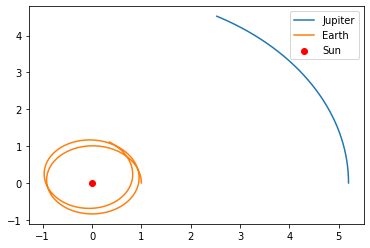

In [33]:
plt.plot(r[1][:,0], r[1][:,1], label="Jupiter")
plt.plot(r[0][:,0], r[0][:,1], label="Earth")
plt.scatter(0,0, label="Sun",c='r')
plt.legend()
plt.savefig('orbit.png')

In [34]:
rj = r[1][::1000]
vj = v[1][::1000]
re = r[0][::1000]
ve = v[0][::1000]
tt = t[::1000]

In [68]:
len(tt)

401

In [35]:
KE = np.array(np.vectorize(KineticEnergy,signature="(n)->()")(ve))
PE = np.array(np.vectorize(PotentialEnergy,signature="(n)->()")(re))
# np.vectorize(AngMomentum,signature="(n)->()")(r[1], v[1])

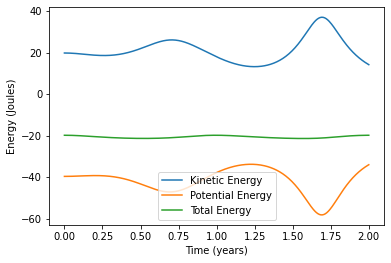

In [36]:
plt.plot(tt, KE, label="Kinetic Energy")
plt.plot(tt, PE, label="Potential Energy")
plt.plot(tt, KE + PE, label="Total Energy")
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Energy (Joules)")
plt.savefig('energy.png')

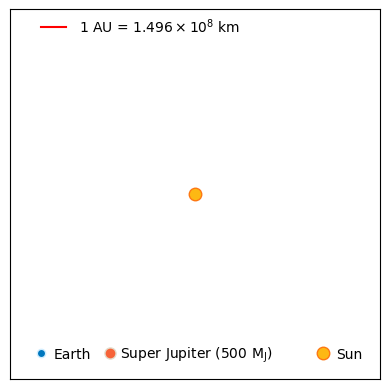

In [12]:
# Function for setting up the animation

fig, ax = plt.subplots()
ax.axis("square")
ax.set_xlim((-7.2, 7.2))
ax.set_ylim((-7.2, 7.2))
ax.get_xaxis().set_ticks([])  # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])  # enable this to hide y axis ticks

ax.plot(0, 0, "o", markersize=9, markerfacecolor="#FDB813", markeredgecolor="#FD7813")
(line1,) = ax.plot(
    [], [], "o-", color="#d2eeff", markevery=10000, markerfacecolor="#0077BE", lw=2
)  # line for Earth
(line2,) = ax.plot(
    [],
    [],
    "o-",
    color="#e3dccb",
    markersize=8,
    markerfacecolor="#f66338",
    lw=2,
    markevery=10000,
)  # line for Jupiter


ax.plot([-6, -5], [6.5, 6.5], "r-")
ax.text(-4.5, 6.3, r"1 AU = $1.496 \times 10^8$ km")

ax.plot(-6, -6.2, "o", color="#d2eeff", markerfacecolor="#0077BE")
ax.text(-5.5, -6.4, "Earth")

ax.plot(-3.3, -6.2, "o", color="#e3dccb", markersize=8, markerfacecolor="#f66338")
ax.text(-2.9, -6.4, r"Super Jupiter (500 $\mathrm{M_J}$)")

ax.plot(
    5, -6.2, "o", markersize=9, markerfacecolor="#FDB813", markeredgecolor="#FD7813"
)
ax.text(5.5, -6.4, "Sun")
ttl = ax.text(0.24, 1.05, "", transform=ax.transAxes, va="center")
# plt.title('Elapsed time, T=%i years' %u)

In [13]:
# initialization animation function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ttl.set_text("")

    return (line1, line2, ttl)

In [14]:
rj = r[1][::1000]
re = r[0][::1000]
tt = t[::1000]

In [15]:
# Animation function. Reads out the positon coordinates sequentially
def animate(i):
    earth_trail = 40
    jupiter_trail = 200
    tm_yr = "Elapsed time = " + str(round(tt[i], 1)) + " years"
    ttl.set_text(tm_yr)
    line1.set_data(
        re[i : max(1, i - earth_trail) : -1, 0], re[i : max(1, i - earth_trail) : -1, 1]
    )
    line2.set_data(
        rj[i : max(1, i - jupiter_trail) : -1, 0],
        rj[i : max(1, i - jupiter_trail) : -1, 1],
    )

    return (line1, line2)

In [16]:
# Call animation function

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=4000, interval=10, blit=True
)

In [17]:
HTML(anim.to_html5_video())

In [5]:
import pandas as pd
data = {
        't':tt,
        're_x':re[:,0],
        're_y':re[:,1],
        've_x':ve[:,0],
        've_y':ve[:,1],
        'rj_x':rj[:,0],
        'rj_y':rj[:,1],
        'vj_x':vj[:,0],
        'vj_y':vj[:,1],
       }

df = pd.DataFrame({k:pd.Series(v) for k,v in data.items()})
df.to_csv("./4e6.csv", index=False)

NameError: name 'tt' is not defined

In [69]:
df = pd.read_csv("./4e6.csv")

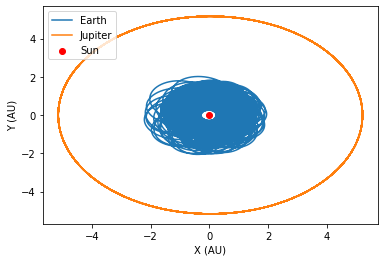

In [168]:
plt.plot(df['re_x'],df['re_y'],label="Earth")
plt.plot(df['rj_x'],df['rj_y'],label="Jupiter")
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.scatter(0,0, label="Sun",c='r')
plt.legend()
plt.savefig('orbits.png')

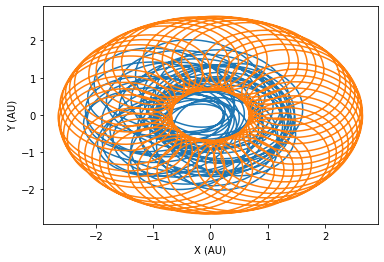

In [170]:
plt.plot(df['re_x'][30000:40000],df['re_y'][30000:40000])
plt.plot(X1[30000:40000],Y1[30000:40000])
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.savefig('differentearth.png')


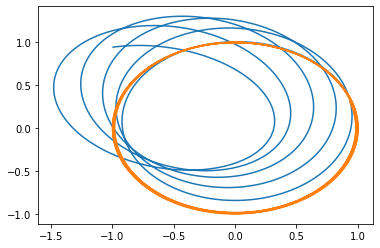

In [154]:
plt.plot(df['re_x'][0:1000],df['re_y'][0:1000])
plt.plot(X1[0:1000]-X0[0:1000],Y1[0:1000]-Y0[0:1000])
plt.savefig('differentearth2.png')

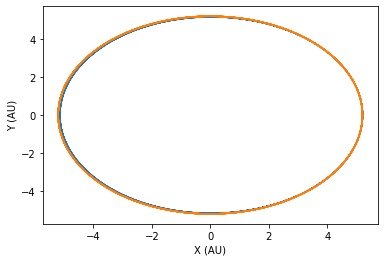

In [169]:
plt.plot(df['rj_x'][30000:40000],df['rj_y'][30000:40000])
plt.plot(X2[30000:40000]-X0[30000:40000],Y2[30000:40000]-Y0[30000:40000])
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.savefig('differentjup.png')

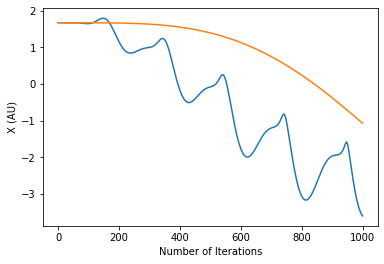

In [162]:
plt.plot(df['re_x'][0:1000]-X1[0:1000])
plt.plot(df['rj_x'][0:1000]-X2[0:1000])
#plt.plot(X1[1:40000],Y1[1:40000])
plt.xlabel('Number of Iterations')
plt.ylabel('X (AU)')
plt.savefig('subtractionendbegin.png')

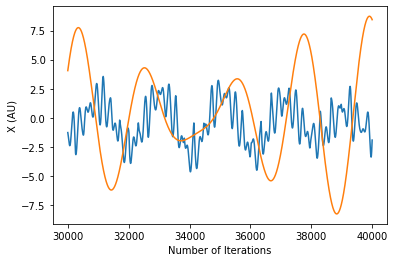

In [164]:
plt.plot(df['re_x'][30000:40000]-X1[30000:40000])
plt.plot(df['rj_x'][30000:40000]-X2[30000:40000])
#plt.plot(X1[1:40000],Y1[1:40000])
plt.xlabel('Number of Iterations')
plt.ylabel('X (AU)')
plt.savefig('subtractionend.png')

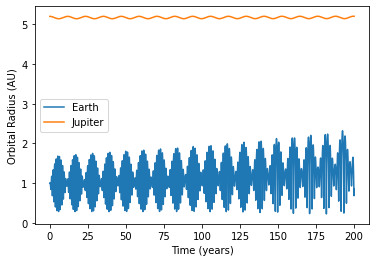

In [157]:
plt.plot(df['t'], np.sqrt(df['re_x']**2+df['re_y']**2), label="Earth")
plt.plot(df['t'], np.sqrt(df['rj_x']**2+df['rj_y']**2), label="Jupiter")
plt.legend()

plt.xlabel("Time (years)")
plt.ylabel("Orbital Radius (AU)")
plt.savefig('axis.png')


In [ ]:
plt.plot()

In [53]:
KE = np.array(np.vectorize(KineticEnergy,signature="(n)->()")([df['ve_x'],df['ve_y']]))
PE = np.array(np.vectorize(PotentialEnergy,signature="(n)->()")([df['re_x'],df['re_y']]))

In [56]:
PE

array([-0.20900251, -0.211957  ])

ValueError: x and y must have same first dimension, but have shapes (40001,) and (2,)

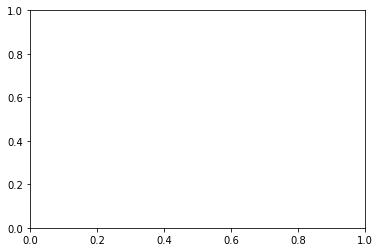

In [55]:
plt.plot(df['t'], KE, label="Kinetic Energy")
plt.plot(df['t'], PE, label="Potential Energy")
plt.plot(df['t'], KE + PE, label="Total Energy")
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Energy (Joules)")
plt.savefig('energys.png')

In [37]:
def AngMomentum(r, v):
    rn = np.linalg.norm(r)
    vn = np.linalg.norm(v)
    r = r / rn
    v = v / vn
    rdotv = r[0] * v[0] + r[1] * v[1]
    theta = math.acos(rdotv)
    return Me * rn * vn * np.sin(theta)

In [40]:
AM_earth = []
AM_jupiter = []

for i in range(len(tt)):
    r = re[i]
    v = ve[i]
    AM_earth.append(AngMomentum(r,v))
    r = rj[i]
    v = vj[i]
    AM_jupiter.append(AngMomentum(r,v))




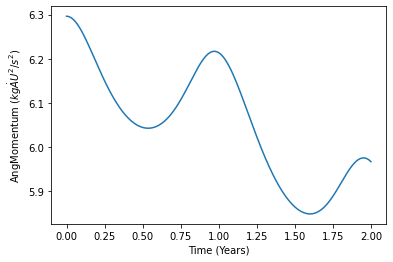

In [160]:
plt.plot(tt, AM_earth, label="Earth")
#plt.plot(AM_jupiter, label="Jupiter")
plt.xlabel('Time (Years)')
plt.ylabel('AngMomentum ($kg\dot AU^2/s^2$)')
plt.savefig('AM.png')

In [39]:
AngMomentum([r[1][0], v[1][0]])

14.315994866310161

In [51]:
AngMomentum([re[0], ve[0]])

6.296290782522899

In [64]:
len(AM_earth)

401

---------------------------------
REBOUND version:     	3.19.3
REBOUND built on:    	Jun 29 2022 01:55:10
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x176ce8540, m=2e+30 x=-1.674575865266528 y=0.0 z=0.0 vx=0.0 vy=-1.0807609222826469 vz=0.0>
<rebound.particle.Particle object at 0x176ce83c0, m=6e+24 x=-0.6745758652665279 y=0.0 z=0.0 vx=0.0 vy=5.2204962146447205 vz=0.0>
<rebound.particle.Particle object at 0x176ce8540, m=9.5e+29 x=3.525427134724472 y=0.0 z=0.0 vx=0.0 vy=2.275253180618954 vz=0.0>
---------------------------------


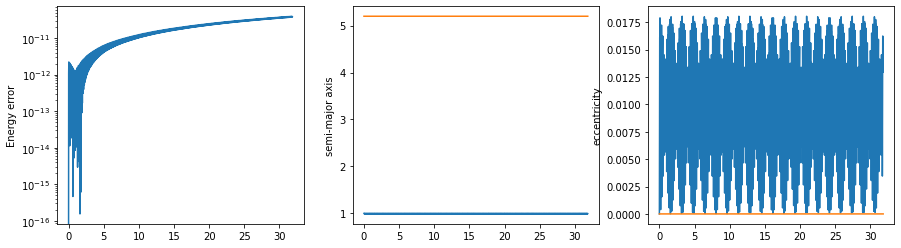

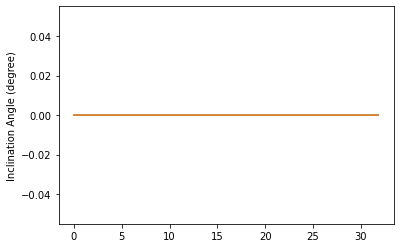

In [124]:
import numpy as np
import rebound 
import random
import matplotlib.pyplot as plt
from tkinter import *

random.seed(1)

sim = rebound.Simulation()
sim.units = ('Yr', 'AU', 'kg')
#sim.units = ('Yr', 'AU', 'Msun')

#radius = 0.005
sim.add(m=2e30)
sim.add(m=6e24, a =1, e=0 )
sim.add(m=1.9e27*500, a=5.2, e=0)
sim.move_to_com()

# sim.add(m=0.00001,x=0.027781409233055013, y=0.0, z=0.0, vx=0.0, vy=31.56175213851367, vz=0.0)
# sim.add(m=0.00001, x=0.01389070461652751*1.0, y=0.0240594061487572, z=0.0, vx=-27.333279139900668*1.01, vy=15.780876069256838*0.99, vz=0.0)



sim.status()

sim.integrator = "whfast"
#sim.dt = min([o.P for o in sim.calculate_orbits()]) * 0.0001 # 5% timestep
sim.dt = min([o.P for o in sim.calculate_orbits(primary=sim.particles[0], jacobi_masses= False)]) * 0.001 # 5% timestep
#os = sim.calculate_orbits(primary=sim.particles[0])
os = sim.calculate_orbits(primary=sim.particles[0], jacobi_masses= False)  # set helio-centric orbit

times = np.arange(0, 200, step=0.005)  #每个周期记录数据的点的间隔由step决定，如果step=0.01,那么每隔0.01个周期记录一个点
#times = np.arange(0, 1
#print(times)
#print(sim.N)
Es = np.zeros(len(times))
As = np.zeros((len(times),sim.N-1))
Eccs = np.zeros((len(times),sim.N-1))
incs = np.zeros((len(times),sim.N-1))
X0 = np.zeros((len(times)))
X1 = np.zeros((len(times)))
X2 = np.zeros((len(times)))
Y0 = np.zeros((len(times)))
Y1 = np.zeros((len(times)))
Y2 = np.zeros((len(times)))
Z0 = np.zeros((len(times)))
Z1 = np.zeros((len(times)))
Z2 = np.zeros((len(times)))
record_time = np.zeros((len(times)))

for j, time in enumerate(times):
    #print(j,time)
    sim.integrate(time)
    Es[j] = sim.calculate_energy()
    os = sim.calculate_orbits()
    record_time[j] =  time
    for i,o in enumerate(os):
        #print(i)
        As[j,i] = o.a
        Eccs[j,i] = o.e
        incs[j,i] = o.inc
        X0[j] = sim.particles[0].x
        Y0[j] = sim.particles[0].y
        Z0[j] = sim.particles[0].z
        X1[j] = sim.particles[1].x
        Y1[j] = sim.particles[1].y
        Z1[j] = sim.particles[1].z
        X2[j] = sim.particles[2].x
        Y2[j] = sim.particles[2].y
        Z2[j] = sim.particles[2].z
#perform_output(sim)
      
fig, axs = plt.subplots(1,3,figsize=(15,4))
axs[0].set_yscale("log")
axs[0].set_ylabel("Energy error")
#axs[1].set_ylim([0.01,20])
#axs[1].set_yscale("log")
axs[1].set_ylabel("semi-major axis")
#axs[2].set_ylim([1e-6,1])
axs[0].set_yscale("log")
axs[2].set_ylabel("eccentricity")

axs[0].plot(times/(np.pi*2.),np.abs((Es-Es[0])/Es[0]))
for i in range(As.shape[1]):
    axs[1].plot(times/(np.pi*2.),As[:,i])
    axs[2].plot(times/(np.pi*2.),Eccs[:,i])
    
plt.figure()
for i in range(As.shape[1]):
    plt.plot(times/(np.pi*2.), incs[:,i]/np.pi*180.0)
plt.ylabel('Inclination Angle (degree)')
plt.show()

# #fig = rebound.OrbitPlot(sim, xlim=[-1,1],ylim=[-1,1])
# fig = rebound.OrbitPlot(sim)

# fig = rebound.OrbitPlot(sim,slices=0.5,xlim=[-2.,2],ylim=[-2.,2])
# sim.status()
# plt.figure()
# plt.plot(record_time*365.24, k1) # when k1 is between [0,1], and x1-x0 > 0, 
#                                  # being transit. 0 corresponsing to transit center
# plt.plot(record_time*365.24, k2)
# #plt.plot(record_time*365.24, (X1-X0)/np.max(X1-X0))
# plt.xlabel('time (day)')
# plt.ylim(-1,1)
# plt.show()

# plt.figure()
# # plt.plot(X2-X0, Y2-Y0)
# # plt.plot(X1-X0, Y1-Y0)
# #plt.xlabel('time (day)')
# #plt.ylim(-1,1)
# plt.show()

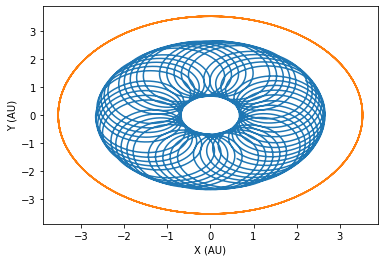

In [161]:
plt.plot(X1[30000:40000],Y1[30000:40000])
plt.plot(X2[30000:40000],Y2[30000:40000])
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.savefig('rebound.png')